In [1]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 6

# Dataset reading

In [4]:
try:
    if not os.path.exists(dataset):
        raise FileNotFoundError(f"Dataset not found at path: {dataset}")

    # Load dataset
    X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
    y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

    if X_dataset.shape[0] == 0 or y_dataset.shape[0] == 0:
        raise ValueError("Dataset is empty.")

    if X_dataset.shape[0] != y_dataset.shape[0]:
        raise ValueError("Mismatch in feature and label dataset sizes.")

except FileNotFoundError as e:
    print(e)
    exit()
except ValueError as e:
    print(f"Error with dataset: {e}")
    exit()
except Exception as e:
    print(f"Unexpected error loading dataset: {e}")
    exit()


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [7]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [9]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [10]:
# Check data shapes
assert X_train.shape[0] == y_train.shape[0], "Mismatch in number of samples between X_train and y_train"
assert X_test.shape[0] == y_test.shape[0], "Mismatch in number of samples between X_test and y_test"

try:
    # Train the model
    model.fit(
        X_train,
        y_train,
        epochs=1000,
        batch_size=128,
        validation_data=(X_test, y_test),
        callbacks=[cp_callback, es_callback]
    )

except MemoryError:
    print("Out-of-memory error encountered. Consider reducing the batch size or using a smaller dataset.")


Epoch 1/1000
20/41 [=============>................] - ETA: 0s - loss: 1.8961 - accuracy: 0.1297 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
41/41 [==============================] - 2s 15ms/step - loss: 1.8523 - accuracy: 0.1560 - val_loss: 1.7560 - val_accuracy: 0.2713
Epoch 2/1000
40/41 [============================>.] - ETA: 0s - loss: 1.7384 - accuracy: 0.2467

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
41/41 [==============================] - 0s 6ms/step - loss: 1.7375 - accuracy: 0.2484 - val_loss: 1.6752 - val_accuracy: 0.3741
Epoch 3/1000
24/41 [================>.............] - ETA: 0s - loss: 1.6899 - accuracy: 0.2959
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
41/41 [==============================] - 0s 5ms/step - loss: 1.6816 - accuracy: 0.3023 - val_loss: 1.5762 - val_accuracy: 0.4603
Epoch 4/1000
23/41 [===============>..............] - ETA: 0s - loss: 1.6223 - accuracy: 0.3349
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
41/41 [==============================] - 0s 5ms/step - loss: 1.6118 - accuracy: 0.3437 - val_loss: 1.4885 - val_accuracy: 0.5345
Epoch 5/1000
20/41 [=============>................] - ETA: 0s - loss: 1.5758 - accuracy: 0.3570
Epoch 5: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
41/41 [=============

In [11]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

14/14 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.9282


In [12]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [13]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 121ms/step
[1.5796074e-01 2.8593255e-02 1.2935599e-04 3.5785150e-02 7.7683473e-01
 6.9672370e-04]
4


# Confusion matrix

55/55 [==============================] - 0s 3ms/step


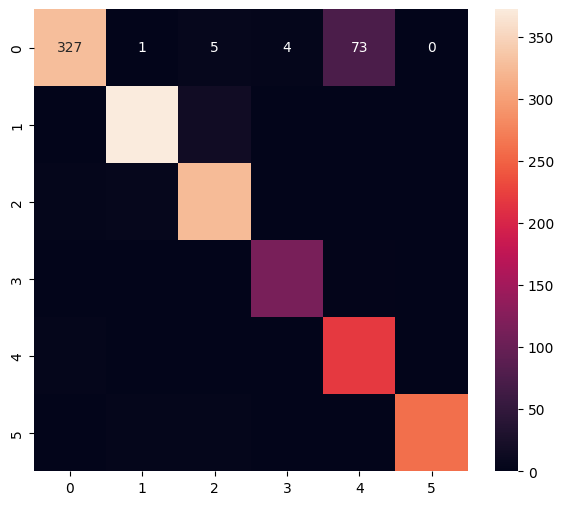

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       410
           1       0.97      0.95      0.96       391
           2       0.93      0.97      0.95       335
           3       0.97      0.97      0.97       117
           4       0.74      0.99      0.85       221
           5       0.99      0.97      0.98       266

    accuracy                           0.93      1740
   macro avg       0.93      0.94      0.93      1740
weighted avg       0.94      0.93      0.93      1740



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [15]:
import os
import tensorflow as tf

try:
    if not os.path.exists(model_save_path):
        raise FileNotFoundError(f"Saved model file not found at {model_save_path}. Ensure the path is correct.")
    
    # Load the model
    model = tf.keras.models.load_model(model_save_path)
    print("Model loaded successfully.")

except FileNotFoundError as fnf_error:
    print(fnf_error)
    # Fallback or notify user for further action
    print("Please check the model save path or ensure the model file is available.")
    exit()

except OSError as os_error:
    print(f"Error loading model: {os_error}. This might be due to an incompatible TensorFlow version.")
    # Provide suggestion for potential fix
    print("Please check TensorFlow version compatibility or try re-saving the model.")
    exit()

except Exception as e:
    print(f"An unexpected error occurred: {e}")
    exit()

Model loaded successfully.


# Inference test

In [16]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [17]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [18]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [19]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [20]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5494089e-01 4.7580963e-03 2.9854893e-04 1.1382532e-02 8.2736522e-01
 1.2546611e-03]
4
